In [23]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow_datasets as tfds
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Load the dataset
ds1, ds2, ds3 = tfds.load('patch_camelyon:2.0.0',
                          split=['train[:20%]', 'test[:5%]', 'validation[:5%]'],
                          data_dir= r'/Users/emmahenneberggram/Documents/3. Semester/DS807 Anvendt Maskinlæring/Eksamen/',
                          download=False,
                          shuffle_files=True)

In [31]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [32]:
# Map and batch the datasets
train_dataset = ds1.map(convert_sample).batch(32)
validation_dataset = ds3.map(convert_sample).batch(32)
test_dataset = ds2.map(convert_sample).batch(32)


In [33]:
# Funktion til at ændre størrelse og normalisere billeder
def resize_and_normalize(image, label):
    # Resize billedet til ønsket størrelse (f.eks. 32x32)
    image = tf.image.resize(image, (128, 128))
    
    # Normalisér billedet til intervallet [0, 1]
    image = image / 255.0
    
    return image, label



In [34]:
# Opret en simpel CNN-model
def first_ccn_model():
    input_img = Input(shape=(128,128,3))
    
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    x = MaxPooling2D()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    y = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model
# Opret model
model = first_ccn_model()

# Opret optimizer
adam_opt = Adam(learning_rate=0.0001)

# Kompilér model
model.compile(optimizer=adam_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


# Tilføj resize og normalisering til træningssættet
train_dataset_resized = train_dataset.map(resize_and_normalize)

# Tilføj resize og normalisering til valideringssættet
validation_dataset_resized = validation_dataset.map(resize_and_normalize)

# Tilføj resize og normalisering til testsættet
test_dataset_resized = test_dataset.map(resize_and_normalize)



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1849

In [35]:
# Træn modelen
hist = model.fit(train_dataset_resized,
                 validation_data=validation_dataset_resized,
                 epochs=20,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/20
1639/1639 [==============================] - 695s 423ms/step - loss: 0.6711 - accuracy: 0.5581 - val_loss: 0.5539 - val_accuracy: 0.7241
Epoch 2/20
1639/1639 [==============================] - 694s 424ms/step - loss: 0.5339 - accuracy: 0.7380 - val_loss: 0.5439 - val_accuracy: 0.7344
Epoch 3/20
1639/1639 [==============================] - 720s 439ms/step - loss: 0.5097 - accuracy: 0.7559 - val_loss: 0.4930 - val_accuracy: 0.7503
Epoch 4/20
1639/1639 [==============================] - 932s 569ms/step - loss: 0.4964 - accuracy: 0.7660 - val_loss: 0.4894 - val_accuracy: 0.7503
Epoch 5/20
1639/1639 [==============================] - 1436s 876ms/step - loss: 0.4842 - accuracy: 0.7717 - val_loss: 0.4922 - val_accuracy: 0.7540
Epoch 6/20
1639/1639 [==============================] - 1709s 1s/step - loss: 0.4767 - accuracy: 0.7758 - val_loss: 0.4730 - val_accuracy: 0.7552
Epoch 7/20
1639/1639 [==============================] - 1608s 981ms/step - loss: 0.4673 - accuracy: 0.7832 - val_

In [43]:
# Evaluering
loss, accuracy = model.evaluate(validation_dataset_resized)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

52/52 [==============================] - 11s 191ms/step - loss: 0.5126 - accuracy: 0.7448
Validation Loss: 0.5125676989555359, Validation Accuracy: 0.7448107600212097


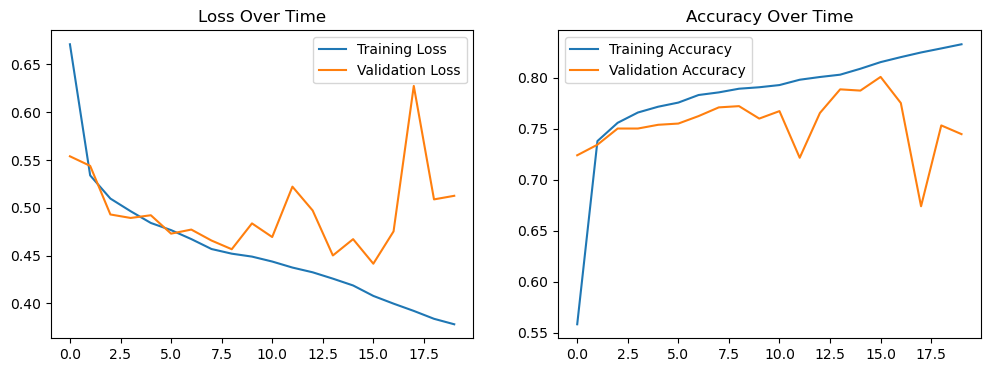

In [44]:
# Visualisering af træningshistorik
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Time')
plt.show()

In [45]:
# Evaluering
loss, accuracy = model.evaluate(test_dataset_resized)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

52/52 [==============================] - 9s 176ms/step - loss: 0.4343 - accuracy: 0.7845
Test Loss: 0.4342723786830902, Test Accuracy: 0.7844932675361633


In [46]:
# Evaluér modellen på testdatasættet
loss, accuracy = model.evaluate(test_dataset_resized)
print(f"Test Accuracy: {accuracy*100:.2f}%")

52/52 [==============================] - 8s 144ms/step - loss: 0.4343 - accuracy: 0.7845
Test Accuracy: 78.45%


52/52 [==============================] - 8s 142ms/step


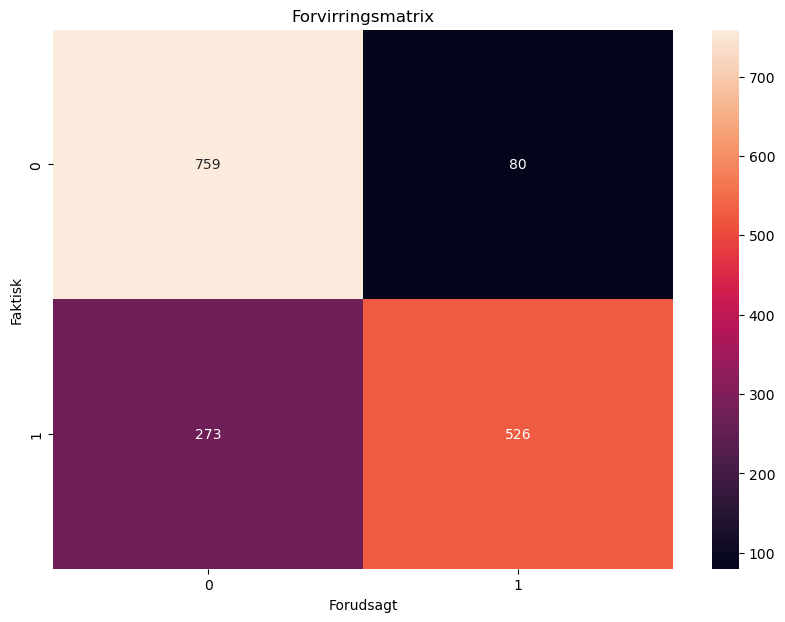

In [47]:
# Forvirringsmatrix
y_pred = model.predict(test_dataset_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

import seaborn as sns

# Plot forvirringsmatricen
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Forudsagt')
plt.ylabel('Faktisk')
plt.title('Forvirringsmatrix')
plt.show()

In [49]:
# Præcision, Genkaldelse, og F1-Score
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.74      0.90      0.81       839
           1       0.87      0.66      0.75       799

    accuracy                           0.78      1638
   macro avg       0.80      0.78      0.78      1638
weighted avg       0.80      0.78      0.78      1638



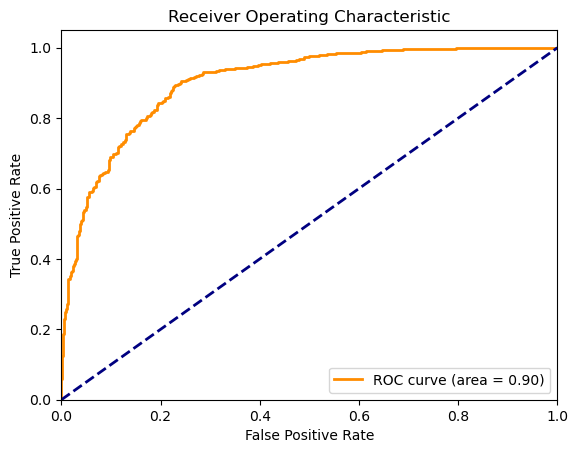

In [50]:
# ROC-kurve og AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()